In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

from tqdm.auto import trange

from sw import sliced_wasserstein

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### MNIST

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()#,
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

### AutoEncoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_shape, d=48):
        super().__init__()
        self.input_shape = input_shape
        self.conv1 = nn.Conv2d(input_shape[0], 3, 
                               kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(3, input_shape[-1], 
                               kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(input_shape[-1], input_shape[-1],
                               kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(input_shape[-1], input_shape[-1],
                               kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(int(input_shape[-1]**3/4), d)
        
        
    def forward(self, x):
        if len(x.shape) == 3:
            x = x[None, ...]

        out = torch.relu(self.conv1(x))
        out = torch.relu(self.conv2(out))
        out = torch.relu(self.conv3(out))
        out = torch.relu(self.conv4(out))
        out = out.view(out.size(0), -1)
        return torch.relu(self.fc1(out))


class Decoder(nn.Module):
    def __init__(self, input_shape, bottleneck_size=48):
        super().__init__()
        self.input_shape = input_shape
        d = input_shape[-1]

        self.fc4 = nn.Linear(bottleneck_size, int(d/2 * d/2 * d))
        self.deconv1 = nn.ConvTranspose2d(d, d,
                                          kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(d, d,
                                          kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(d, d,
                                          kernel_size=2, stride=2, padding=0)
        self.conv5 = nn.Conv2d(d, self.input_shape[0],
                               kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        d = self.input_shape[-1]
        out = torch.relu(self.fc4(x))
        out = out.view(-1, d, int(d/2), int(d/2))
        out = torch.relu(self.deconv1(out))
        out = torch.relu(self.deconv2(out))
        out = torch.relu(self.deconv3(out))
        return torch.sigmoid(self.conv5(out))


class AE(nn.Module):
    def __init__(self, input_shape, d=48):
        super().__init__()
        self.encoder = Encoder(input_shape, d)
        self.decoder = Decoder(input_shape, d)
    
    def forward(self, x):
        z = self.encoder(x)        
        y = self.decoder(z)
        return y

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_shape, d=48):
        super().__init__()
        self.input_shape = input_shape
        self.conv1 = nn.Conv2d(input_shape[0], 3, 
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(3, input_shape[-1], 
                               kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, padding=0)
        self.conv3 = nn.Conv2d(input_shape[-1], input_shape[-1]*2,
                               kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(input_shape[-1]*2, input_shape[-1]*2,
                               kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, padding=0)
        self.conv5 = nn.Conv2d(input_shape[-1]*2, input_shape[-1]*4, 
                               kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(input_shape[-1]*4, input_shape[-1]*4,
                               kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool2d(kernel_size=2, padding=1)        
        
        self.fc1 = nn.Linear(int(input_shape[-1]*4*4*4), 128)
        self.fc2 = nn.Linear(128, d)
                
        
    def forward(self, x):
        if len(x.shape) == 3:
            x = x[None, ...]

        out = F.leaky_relu(self.conv1(x), 0.2)
#         print(out.size(), self.conv2(out).size(), F.leaky_relu(self.conv2(out), 0.2).size())
#         print(self.pool1(F.leaky_relu(self.conv2(out), 0.2)).size())
        out = self.pool1(F.leaky_relu(self.conv2(out), 0.2))
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = self.pool2(F.leaky_relu(self.conv4(out), 0.2))
        out = F.leaky_relu(self.conv5(out), 0.2)
        out = self.pool3(F.leaky_relu(self.conv6(out), 0.2))
        out = out.view(out.size(0), -1)
        out = torch.relu(self.fc1(out))
        return self.fc2(out)
    

class Decoder(nn.Module):
    def __init__(self, input_shape, bottleneck_size=48):
        super().__init__()
        self.input_shape = input_shape
        d = input_shape[-1]

        self.fc4 = nn.Linear(bottleneck_size, 128)
        self.fc5 = nn.Linear(128, d*4*4*4)
        
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv1 = nn.Conv2d(d*4, d*4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(d*4, d*4, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(d*4, d*4, kernel_size=3, padding=0)
        self.conv4 = nn.Conv2d(d*4, d*2, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(d*2, d*2, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(d*2, d*2, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(d*2, 1, kernel_size=3, padding=1)
    
    def forward(self, x):
        d = self.input_shape[-1]
        out = torch.relu(self.fc5(self.fc4(x)))
        out = out.view(-1, 4*d, 4, 4)
        
        out = F.leaky_relu(self.conv1(self.upsample(out)), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(self.upsample(out)), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        out = F.leaky_relu(self.conv5(self.upsample(out)), 0.2)
        out = F.leaky_relu(self.conv6(out), 0.2)
        
        out = torch.sigmoid(self.conv7(out))
        return out

### SWAE

In [6]:
criterion = nn.BCELoss(reduction='sum')

def ae_loss(x, y, z):
    n, d = z.size()
    target_latent = -1+2*torch.rand(n, d, device=device)
    sw = sliced_wasserstein(z, target_latent, 1000, device, p=2)
    l1 = F.l1_loss(y, x) # torch.mean(torch.abs(x-y))
    reconstruction_loss = criterion(y, x)
    
#     print("SW", sw.item(), "BCE", reconstruction_loss.item(), "L1", l1.item())
#     fig, ax = plt.subplots(1,2,figsize=(15,7))
#     ax[0].scatter(target_latent[:,0].cpu(), target_latent[:,1].cpu())
#     ax[1].scatter(z[:,0].detach().cpu(), z[:,1].detach().cpu())
#     plt.show()
    
    return reconstruction_loss+l1+10.0*sw

In [7]:
model = AE(train_loader.dataset[0][0].shape, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, alpha=0.9)

0 538.3682369836781 157.37307666132625


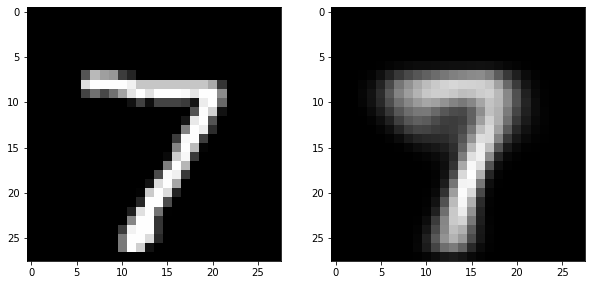

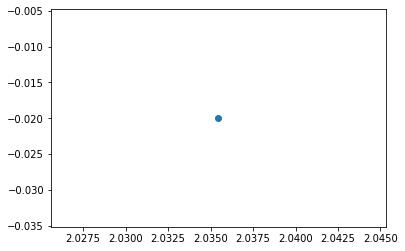

1 154.27556532566314 146.53900690048266


In [ ]:
n_epochs = 50

pbar = trange(n_epochs)

losses = []
val_losses = []

for e in pbar:
    loss_epoch = 0
    cpt_batch = 0
    
    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        
        model.train()
        
        z_hat = model.encoder(x_batch)
        y_hat = model.decoder(z_hat)
        
        l = ae_loss(x_batch, y_hat, z_hat)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_epoch += l.item()/x_batch.size(0)
        cpt_batch += 1

    losses.append(loss_epoch/cpt_batch)
    
    loss_val_epoch = 0
    cpt_batch = 0
        
    with torch.no_grad():
        for x_val, _ in test_loader:
            x_val = x_val.to(device)
            
            model.eval()
            zhat = model.encoder(x_val)
            yhat = model.decoder(zhat)
            val_l = ae_loss(x_val,yhat,zhat)
            loss_val_epoch += val_l.item()/x_val.size(0)
            cpt_batch += 1
            
        val_losses.append(loss_val_epoch/cpt_batch)

    print(e,losses[-1],val_losses[-1])
        
    if e%5 == 0:  
        for x_val, _ in test_loader:
            fig,ax = plt.subplots(1,2,figsize=(10,10))

            ax[0].imshow(x_val[0][0],"gray")

            x_val = x_val.to(device)

            model.eval()
            yhat = model(x_val[0][0].reshape(-1,28,28))
            yhat = yhat.reshape(-1,1,28,28)
            ax[1].imshow(yhat[0][0].cpu().detach().numpy(),"gray")
            plt.show()
            
            z = model.encoder(x_val[0][0].reshape(-1,28,28)).detach().cpu()
            plt.scatter(z[:,0], z[:,1])
            plt.show()
        
            break
        

In [ ]:
plt.plot(losses)
plt.plot(val_losses)
plt.show()

In [ ]:
dataiter = iter(train_loader)

X, Y = next(dataiter)
data = X.to(device)
z = model.encoder(data)
y = model.decoder(z)

In [ ]:
# Distribution of the encoded samples
z = z.detach().cpu()

plt.figure(figsize=(10,10))
plt.scatter(z[:,0],-z[:,1],c=10*Y, cmap=plt.cm.Spectral)
# plt.xlim([-1.5,1.5])
# plt.ylim([-1.5,1.5])
plt.show()

In [ ]:
z.size()

In [ ]:
Y